# Autor: Yandry Daniel Romero Carrión

El modelo epidémico de SIR

Una descripción matemática simple de la propagación de una enfermedad en una población es el llamado modelo SIR, que divide la población (fija) de N individuos en tres "compartimentos" que pueden variar en función del tiempo, t:

S(t) son aquellos susceptibles pero aún no infectados con la enfermedad;
I(t) es el número de individuos infecciosos;
R(t) son aquellas personas que se han recuperado de la enfermedad y ahora tienen inmunidad.
El modelo SIR describe el cambio en la población de cada uno de estos compartimentos en términos de dos parámetros, beta y gamma.

Beta describe la tasa de contacto efectiva de la enfermedad: un individuo infectado entra en contacto con beta*N otros individuos por unidad de tiempo (de los cuales la fracción que es susceptible a contraer la enfermedad es S/N).
Gamma es la tasa de recuperación promedio: es decir, 1/ gamma es el período de tiempo promedio durante el cual una persona infectada puede transmitirlo.
Las ecuaciones diferenciales que describen este modelo fueron derivadas primero por Kermack y McKendrick [ Proc. R. Soc. A , 115 , 772 (1927)]:

$$\begin{align*}
\frac{\mathrm{d}S}{\mathrm{d}t} &amp;= -\frac{\beta S I}{N},\\
\frac{\mathrm{d}I}{\mathrm{d}t} &amp;= \frac{\beta S I}{N} - \gamma I,\\
\frac{\mathrm{d}R}{\mathrm{d}t} &amp;= \gamma I.
\end{align*}$$

In [5]:
import pandas as pd
import numpy as np
from datetime import timedelta, datetime
import altair as alt
import matplotlib.pyplot as plt
import scipy.integrate as spi
from scipy.optimize import minimize
from scipy.integrate import solve_ivp
from scipy.integrate import odeint
from easydict import EasyDict as easydict
print("Librerias Importadas")

Librerias Importadas


In [6]:
# Total de la poblacion
N = 15000
# Numero Inicial de Infectados
I0 = 1
# Numero de Recuperados
R0 = 0
# Todos los demás, S0, son susceptibles a la infección inicialmente.
S0 = N - I0 - R0
# Tasa de contacto, beta (nivel de repoductividad del virus) 
# La tasa de recuperación media, gamma,(1/días) Una persona se recupera en 15 dias.
beta, gamma = 0.4, 1.0/5 
# Una cuadrícula de puntos de tiempo (en días)
t = np.linspace(0, 200, 200)

In [7]:
# Las ecuaciones diferenciales del modelo SIR..
def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N 
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

In [8]:
# Vector de condiciones iniciales
y0 = S0, I0, R0
# Integre las ecuaciones SIR en la cuadrícula de tiempo, t. A traves de la funcion odeint()
ret = odeint(deriv, y0, t, args=(N, beta, gamma))
S, I, R = ret.T # Obtenicion de resultados

In [9]:
df = pd.DataFrame({'time':t.astype('int'),'susceptible':S/N,'infected':I/N,'recovered':R/N})
df.head(5)

,time,susceptible,infected,recovered
0,0,0.999933,0.000067,0.000000
1,1,0.999904,0.000082,0.000015
2,2,0.999867,0.000100,0.000033
3,3,0.999823,0.000122,0.000055
4,4,0.999769,0.000149,0.000082


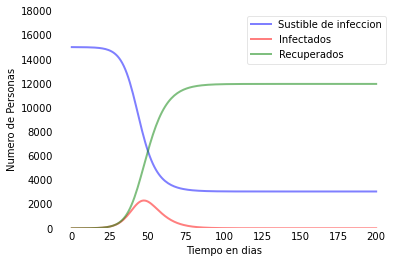

2.0


In [10]:
#  Trace los datos en tres curvas separadas para S (t), I (t) y R (t)
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111,  axisbelow=True)
ax.plot(t, S, 'b', alpha=0.5, lw=2, label='Sustible de infeccion')
ax.plot(t, I, 'r', alpha=0.5, lw=2, label='Infectados')
ax.plot(t, R, 'g', alpha=0.5, lw=2, label='Recuperados')
ax.set_xlabel('Tiempo en dias')
ax.set_ylabel('Numero de Personas')
ax.set_ylim(0,N*1.2)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

Ro = beta/gamma
print(Ro)

# Predicion del modelo SIR para el Ecuador

Implementar solo teniendo en cuenta los casos confirmados

Como primer paso creamos nuestras variables iniciales para la simulación, para nuestro caso en IO le decimos que van a existir i0 infectados, en RO 0 recuperados y 10 millones de cuceptibles y le pasamos como parametro Ecuador para que nos realize un filtrado.

In [17]:
def parse_arguments():
    args = easydict({
        "countries":"Ecuador",
        "download_data":False,
        "start_date":"2/29/20",
        "predict_range":150,
        "s_0":100000,
        "i_0":10,
        "r_0":0,
    })

    country_list = ["Ecuador"]
    return (country_list, args.download_data, args.start_date, args.predict_range, args.s_0, args.i_0, args.r_0)


Definimos dos métodos para descargar datos reales en tiempo actualizado y métodos de lectura

In [28]:
def download_data(url_dictionary):
    #Lets download the files
    for url_title in url_dictionary.keys():
        urllib.request.urlretrieve(url_dictionary[url_title], "./data/" + url_title)


def load_json(json_file_str):
    # Loads  JSON into a dictionary or quits the program if it cannot.
    try:
        with open(json_file_str, "r") as json_file:
            json_variable = json.load(json_file)
            return json_variable
    except Exception:
        sys.exit("Cannot open JSON file: " + json_file_str)

Creamos una clase de aprendizaje en cual recibimos nuestros datos definidos al inicio y luego cargamos nuestro dataset y le realozamos un filtrado para que solo nos muestre los datos de Ecuados, tambien dentro de aquí vamos a definir nuestra predicción en el cual vamos a utilizar alfa y omega, tambien en este metodo lo vamos a llamar train para realziat un entrenamiento en los datos

In [18]:
class Learner(object):
    def __init__(self, country, loss, start_date, predict_range,s_0, i_0, r_0):
        self.country = country
        self.loss = loss
        self.start_date = start_date
        self.predict_range = predict_range
        self.s_0 = s_0
        self.i_0 = i_0
        self.r_0 = r_0


    def load_confirmed(self, country):
        df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
        country_df = df[df['Country/Region'] == country]
        return country_df.iloc[0].loc[self.start_date:]


    def load_recovered(self, country):
        df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')
        country_df = df[df['Country/Region'] == country]
        return country_df.iloc[0].loc[self.start_date:]


    def load_dead(self, country):
        df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
        country_df = df[df['Country/Region'] == country]
        return country_df.iloc[0].loc[self.start_date:]
    

    def extend_index(self, index, new_size):
        values = index.values
        current = datetime.strptime(index[-1], '%m/%d/%y')
        while len(values) < new_size:
            current = current + timedelta(days=1)
            values = np.append(values, datetime.strftime(current, '%m/%d/%y'))
        return values

    def predict(self, beta, gamma, data, recovered, death, country, s_0, i_0, r_0):
        new_index = self.extend_index(data.index, self.predict_range)
        size = len(new_index)
        def SIR(t, y):
            S = y[0]
            I = y[1]
            R = y[2]
            return [-beta*S*I, beta*S*I-gamma*I, gamma*I]
        extended_actual = np.concatenate((data.values, [None] * (size - len(data.values))))
        extended_recovered = np.concatenate((recovered.values, [None] * (size - len(recovered.values))))
        extended_death = np.concatenate((death.values, [None] * (size - len(death.values))))
        return new_index, extended_actual, extended_recovered, extended_death, solve_ivp(SIR, [0, size], [s_0,i_0,r_0], t_eval=np.arange(0, size, 1))


    def train(self):
        recovered = self.load_recovered(self.country)
        death = self.load_dead(self.country)
        data = (self.load_confirmed(self.country))
        
        optimal = minimize(loss, [0.001, 0.001], args=(data, recovered, self.s_0, self.i_0, self.r_0), method='L-BFGS-B', bounds=[(0.00000001, 0.4), (0.00000001, 0.4)])
        print(optimal)
        beta, gamma = optimal.x
        new_index, extended_actual, extended_recovered, extended_death, prediction = self.predict(beta, gamma, data, recovered, death, self.country, self.s_0, self.i_0, self.r_0)
        df = pd.DataFrame({'Infectados': extended_actual,'Susceptible': prediction.y[0], 'Infected': prediction.y[1], 'Recovered': prediction.y[2]}, index=new_index)
        fig, ax = plt.subplots(figsize=(15, 10))
        ax.set_title(self.country)
        df.plot(ax=ax)
        print(f"country={self.country}, beta={beta:.8f}, gamma={gamma:.8f}, r_0:{(beta/gamma):.8f}")

Y aquí definimos nuestra función para optimizar y obtener mejores resultados

In [19]:
def loss(point, data, recovered, s_0, i_0, r_0):
    size = len(data)
    beta, gamma = point
    def SIR(t, y):
        S = y[0]
        I = y[1]
        R = y[2]
        return [-beta*S*I, beta*S*I-gamma*I, gamma*I]
    solution = solve_ivp(SIR, [0, size], [s_0,i_0,r_0], t_eval=np.arange(0, size, 1), vectorized=True)
    alpha = 0.1
    return np.sqrt(np.mean((solution.y[1] - data)**2))

Luego definimos los parametros que vamos a utilziar en nuestro modelo de simulación

In [20]:
countries, download, startdate, predict_range , s_0, i_0, r_0 = parse_arguments()

In [21]:
if download:
        data_d = load_json("./data_url.json")
        download_data(data_d)

Como punto final le decimos que recorra el país que ya detrminamos que en este caso sería Ecuador y llamamos a las funciones con el paso de parametros y simualmos nuestro modelo.

      fun: 110737.10755575412
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([5.31910958e+08, 1.84861381e+07])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 66
      nit: 2
     njev: 22
   status: 0
  success: True
        x: array([4.52464319e-06, 4.52464319e-06])
country=Ecuador, beta=0.00000452, gamma=0.00000452, r_0:1.00000000


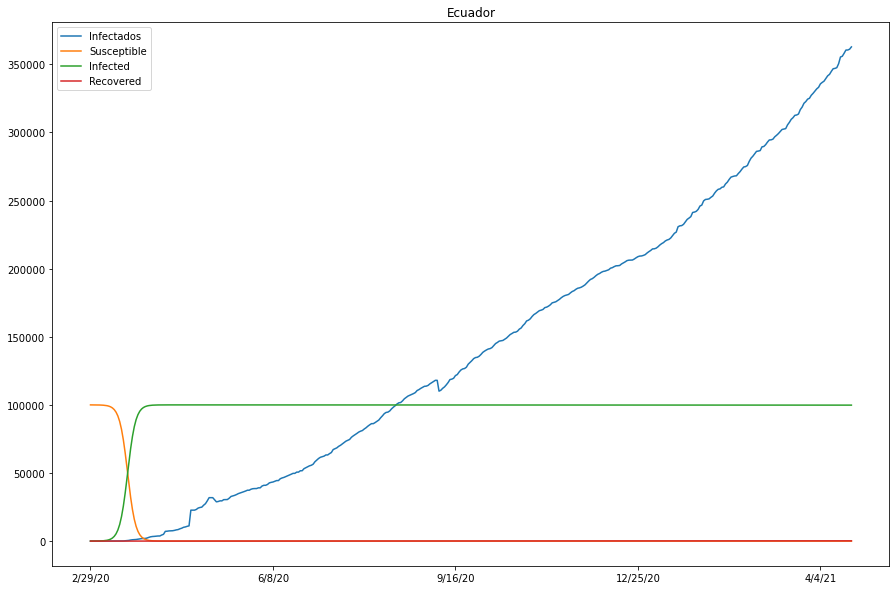

In [22]:
for country in countries:
        learner = Learner(country, loss, startdate, predict_range, s_0, i_0, r_0)
        learner.train()

Incidencia y Prevalencia de nuestro modelo 

Para este caso nosotros definimos nuestra población, de la misma manera le decimos desde que fecha queremos que nos calcule e imprimos los resultados

In [27]:
poblacion = 18500

df3 = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
country_df3 = df3[df3['Country/Region'] == "Ecuador"]
confirmados = country_df3.iloc[0].loc["2/29/20":]

ultimo=confirmados[len(confirmados)-1]
anteultimo=confirmados[len(confirmados)-2]
nuevoscasos=ultimo-anteultimo
riesgo= poblacion - ultimo
incidencia = (nuevoscasos/riesgo)*pow(10, 3)
print('Incidencia: ',incidencia)
prevalencia = (ultimo/poblacion)*pow(10, 3) 
print('Prevalencia: ', prevalencia)


Incidencia:  -4.904992986644132
Prevalencia:  19613.135135135133


# Análisis

Como se puede observar para nuestra simulación en el primer caso no tomamos en cuenta las personas recuperadas por que los datos que le pasamos solo fue de las personas confirmadas, para realziar la simualción de los recuperados se debería cambiar los parametros y obtenemos una simulación más precisa y eficaz.

# Conclusión

El modelo SIR nos permite obtener resultados y simulaciones de lo que actualmete estamos viviendo y obtener resulados estadisticos que nos permiten ver la magnitud en la que estamos atravesando, también podemos ver el número de contagiados y como día a día van aumentando sucesivamnete, en el cual ya podemos dar una tendencia y observar las curvas de la pandemia.

# Referencias 

https://www.agenciasinc.es/Reportajes/Un-modelo-un-teorema-y-teoria-de-juegos-contra-el-coronavirus
https://rpubs.com/dsfernandez/422937
https://towardsdatascience.com/modelling-the-coronavirus-epidemic-spreading-in-a-city-with-python-babd14d82fa2